# CNN

In [1]:
!pip install scikit-image

In [1]:
import os
import numpy as np
import pandas as pd
from skimage import exposure
import matplotlib.pyplot as plt
import cv2
from ast import literal_eval
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
import tensorflow.keras.backend as K
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

2021-11-15 11:27:57.368747: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
df_metadata = pd.read_csv('size.csv')
df_metadata['id'] = df_metadata['id'].str.replace('.jpg', '.png')
df_metadata.head(3)

,id,dim0,dim1,split
0,a29c5a68b07b.png,2320,2828,test
1,9850b5470fd6.png,2330,2382,test
2,8d6dea06a032.png,2422,3344,test


In [3]:
df_image = pd.read_csv('../../train_image_level_without_dupls.csv')
df_study = pd.read_csv('../../train_study_level_without_dupls.csv')

# merge two dataset for ease manipulation
df_study['id'] = df_study['id'].str.replace('_study', '')
df_study.rename({'id' : 'StudyInstanceUID'}, axis=1, inplace=True)
df_train = df_image.merge(df_study, on='StudyInstanceUID')

# create new col for label class
df_train.loc[df_train['Typical Appearance']==1, 'study_label'] = 'typical'
df_train.loc[df_train['Indeterminate Appearance']==1, 'study_label'] = 'indeterminate'
df_train.loc[df_train['Atypical Appearance']==1, 'study_label'] = 'atypical'
df_train.drop(['Negative for Pneumonia','Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance'], axis=1, inplace=True)


df_train['id'] = df_train['id'].str.replace('_image', '.png')

# split label for just getting opacity/none label
df_train['image_label'] = df_train['label'].str.split().apply(lambda x : x[0])
df_train = df_train.merge(df_metadata, on='id')

df_train.head(3)

,id,boxes,label,StudyInstanceUID,study_label,image_label,dim0,dim1,split
0,000a312787f2.png,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,typical,opacity,3488,4256,train
1,000c3a3f293f.png,NaN,none 1 0 0 1 1,ff0879eb20ed,NaN,none,2320,2832,train
2,0012ff7358bc.png,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,typical,opacity,2544,3056,train


In [4]:
df_train.head()

,id,boxes,label,StudyInstanceUID,study_label,image_label,dim0,dim1,split
0,000a312787f2.png,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,typical,opacity,3488,4256,train
1,000c3a3f293f.png,NaN,none 1 0 0 1 1,ff0879eb20ed,NaN,none,2320,2832,train
2,0012ff7358bc.png,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,typical,opacity,2544,3056,train
3,001398f4ff4f.png,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,atypical,opacity,3520,4280,train
4,001bd15d1891.png,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,typical,opacity,2800,3408,train


In [5]:
all_files = []
for dirname, _, filenames in os.walk('train-512-png'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))

In [6]:
def preprocess_image(img):
    equ_img = exposure.equalize_adapthist(img/255, clip_limit=0.05, kernel_size=24)
    return equ_img

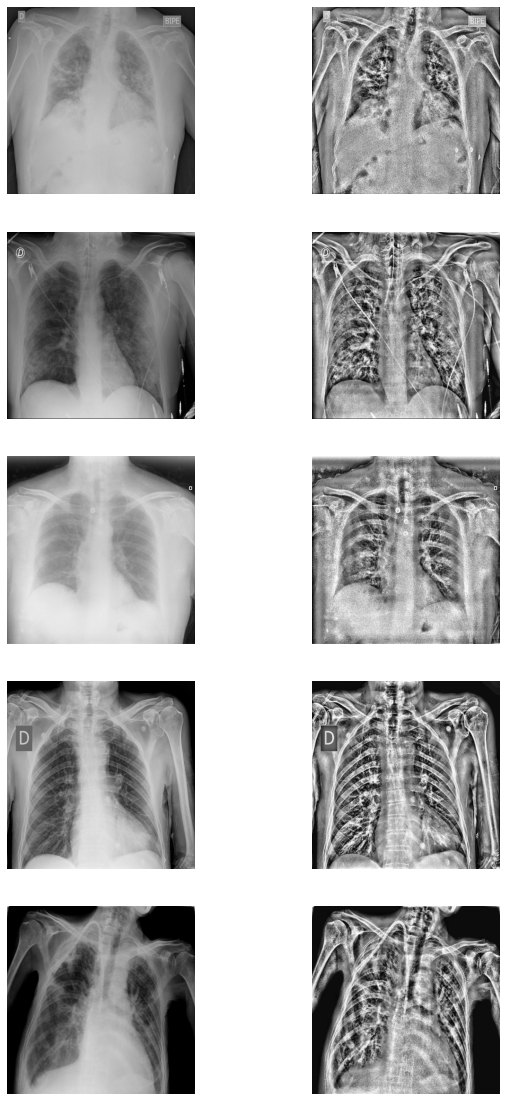

In [7]:

df_opa = df_train[df_train['image_label'] == 'opacity'].reset_index()
fig, axs = plt.subplots(5, 2, figsize=(10,20))
fig.subplots_adjust(hspace=.2, wspace=.2)
n = 5
for i in range(n):
    img = cv2.imread(os.path.join(all_files[i]))
    img_proc = preprocess_image(img)
    axs[i, 0].imshow(img)
    axs[i, 1].imshow(img_proc)
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.show()

In [8]:
img_size = 512
batch_size = 16

image_generator = ImageDataGenerator(
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
    preprocessing_function=preprocess_image
    
)

image_generator_valid = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_image)

train_generator = image_generator.flow_from_dataframe(
    dataframe=df_train,
    directory='train-512-png',#<=== CAMBIAR ESTO POR EL DIRECTORIO DONDE ESTAN LAS PNGS
    x_col='id',
    y_col='image_label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    seed=23
)
valid_generator = image_generator.flow_from_dataframe(
    dataframe=df_train,
    directory='train-512-png', # <=== CAMBIAR ESTO POR EL DIRECTORIO DONDE ESTAN LAS PNGS
    x_col='id',
    y_col='image_label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    shuffle=False,
    seed=23
)

Found 4817 validated image filenames belonging to 2 classes.
Found 1204 validated image filenames belonging to 2 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [10]:
forma_imagen = (512,512,3)

In [11]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = forma_imagen, activation = 'relu',))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = forma_imagen, activation = 'relu',))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = forma_imagen, activation = 'relu',))
model.add(MaxPooling2D(pool_size = (2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts ayudan a reducir el sobre ajuste al ir "apagando" neuronas al azar durante el entrenamiento.
# Aquí estamos indicando que al azar apague el 50% de las neuronas.
model.add(Dropout(0.5))

# La última capa, recordamos que es binaria por lo que selecionamos sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

2021-11-15 11:30:09.986662: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-15 11:30:10.034908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 11:30:10.035097: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2021-11-15 11:30:10.035134: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-11-15 11:30:10.089236: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-11-15 11:30:10.117927: I tensorflow/stream_executor/pl

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0

In [14]:
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.1, patience = 2, verbose = 1, 
                                min_delta = 1e-4, min_lr = 1e-6, mode = 'min')
es = EarlyStopping(monitor = 'loss', min_delta = 1e-4, patience = 5, mode = 'min', 
                    restore_best_weights = True, verbose = 1)
ckp = ModelCheckpoint('model.h5',monitor = 'loss',
                      verbose = 0, save_best_only = True, mode = 'min')
history = model.fit(
      train_generator,
      epochs=25,
      callbacks=[es, rlr, ckp],
      verbose=1)

K.clear_session()

Epoch 1/25
302/302 [==============================] - 1537s 5s/step - loss: 0.7234 - accuracy: 0.5000
Epoch 2/25
302/302 [==============================] - 1535s 5s/step - loss: 0.6931 - accuracy: 0.5000
Epoch 3/25
302/302 [==============================] - 1522s 5s/step - loss: 0.6931 - accuracy: 0.5000
Epoch 4/25
302/302 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
302/302 [==============================] - 1526s 5s/step - loss: 0.6931 - accuracy: 0.5000
Epoch 5/25
302/302 [==============================] - 1531s 5s/step - loss: 0.6931 - accuracy: 0.5000
Epoch 6/25
302/302 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
302/302 [==============================] - 1523s 5s/step - loss: 0.6931 - accuracy: 0.5000
Epoch 7/25
302/302 [==============================] - 15

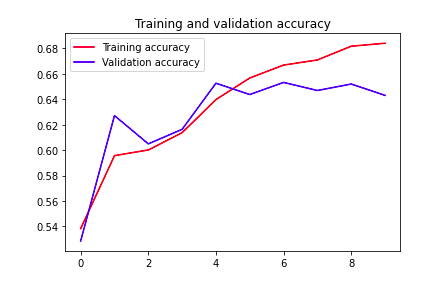

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()